In [3]:
import numpy as np
import pandas as pd

data_path = "../data/bike-sharing-demand/"

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sampleSubmission.csv')

## 피쳐 엔지니어링

In [4]:
# 이전 결과에 맞게 이상치 제거

train = train[train['weather'] != 4]

In [5]:
all_data = pd.concat([train, test], ignore_index=True)
print(all_data.head())
all_data.tail()

              datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0     3.0        13.0   16.0  
1        80        0.0     8.0        32.0   40.0  
2        80        0.0     5.0        27.0   32.0  
3        75        0.0     3.0        10.0   13.0  
4        75        0.0     0.0         1.0    1.0  


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
17373,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17374,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17375,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
17376,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN
17377,2012-12-31 23:00:00,1,0,1,1,10.66,13.635,65,8.9981,NaN,NaN,NaN


In [6]:
# 파생피처 생성
from datetime import datetime
all_data['date'] = all_data['datetime'].apply(lambda x: x.split()[0])

all_data['year'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[0])
all_data['month'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[1])
all_data['hour'] = all_data['datetime'].apply(lambda x: x.split()[1].split(':')[0])
all_data['weekday'] = all_data['date'].apply(lambda dateString: datetime.strptime(dateString, "%Y-%m-%d").weekday())

In [7]:
# 필요없는 피쳐 제거

drop_features = ['casual', 'registered', 'datetime', 'date', 'month', 'windspeed']
all_data = all_data.drop(drop_features, axis = 1)

In [8]:
X_train = all_data[~pd.isnull(all_data['count'])] # Y가 없음.
X_test = all_data[pd.isnull(all_data['count'])] # Y가 있음.

X_train = X_train.drop(['count'], axis = 1)
X_test = X_test.drop(['count'], axis = 1)
y = train['count']

In [9]:
X_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,year,hour,weekday
0,1,0,0,1,9.84,14.395,81,2011,00,5
1,1,0,0,1,9.02,13.635,80,2011,01,5
2,1,0,0,1,9.02,13.635,80,2011,02,5
3,1,0,0,1,9.84,14.395,75,2011,03,5
4,1,0,0,1,9.84,14.395,75,2011,04,5


## BaseLine

In [10]:
import numpy as np

# Method 1. 수기 계산
def rmsle(y_true, y_pred, convertExp=True):
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
    
    log_true = np.nan_to_num(np.log(y_true+1))
    log_pred = np.nan_to_num(np.log(y_pred-1))

    output = np.sqrt(np.mean((log_true - log_pred) ** 2))
    return output

In [11]:
from sklearn.linear_model import LinearRegression

linear_reg_model = LinearRegression()

log_y = np.log(y)
linear_reg_model.fit(X_train, log_y)

preds = linear_reg_model.predict(X_train)
print(f'선형 회귀의 RMSLE 값: {rmsle(log_y, preds, True):.4f}')
# 당연히 검증 데이터를 써야하지만 우선은 테스트!!!

선형 회귀의 RMSLE 값: 1.0201


In [12]:
linearreg_preds = linear_reg_model.predict(X_test)

submission['count'] = np.exp(linearreg_preds)
submission.to_csv(data_path +'submission.csv', index = False)

## 성능 개선

### 성능개선1. 릿지 회귀모델

In [17]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

ridge_model = Ridge()

In [18]:
ridge_params = {'max_iter': [3000], 'alpha': [0.1,1,2,3,4,10,30,100,200,300,400,800,900,1000]}

rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better= False) # 평가지표 제작

gridsearch_ridge_model = GridSearchCV(estimator=ridge_model,
                                      param_grid= ridge_params,
                                      scoring= rmsle_scorer,
                                      cv = 5)

In [21]:
log_y = np.log(y)
gridsearch_ridge_model.fit(X_train, log_y)
print(gridsearch_ridge_model.best_params_)

{'alpha': 0.1, 'max_iter': 3000}


In [22]:
preds = gridsearch_ridge_model.best_estimator_.predict(X_train)
print(f"릿지 회귀: {rmsle(log_y, preds, True):.4f}")

릿지 회귀: 1.0201


### 성능개선2. 라쏘 회귀모델

In [23]:
from sklearn.linear_model import Lasso

lasso_model = Lasso()
lasso_alpha = 1/np.array([0.1,1,2,3,4,10,30,100,200,300,400,800,900,1000])
lasso_params = {'max_iter':[3000], 'alpha': lasso_alpha}

gridsearch_lasso_model = GridSearchCV(estimator= lasso_model,
                                      param_grid= lasso_params,
                                      scoring=rmsle_scorer,
                                      cv=5)

log_y = np.log(y)
gridsearch_lasso_model.fit(X_train, log_y)

print(gridsearch_lasso_model.best_params_)

{'alpha': 0.0025, 'max_iter': 3000}


In [25]:
preds = gridsearch_lasso_model.best_estimator_.predict(X_train)

print(f"라쏘 회귀 RMSLE 값: {rmsle(log_y, preds, True):.4f}")

라쏘 회귀 RMSLE 값: 1.0200


### 성능개선3. RandomForest

In [26]:
from sklearn.ensemble import RandomForestRegressor

randomforest_model = RandomForestRegressor()
rf_params = {'random_state': [42], 'n_estimators': [100,120,140]}
gridsearch_rf_model = GridSearchCV(estimator=randomforest_model,
                                   param_grid=rf_params,
                                   scoring=rmsle_scorer,
                                   cv=5)

log_y = np.log(y)
gridsearch_rf_model.fit(X_train, log_y)

print(gridsearch_rf_model.best_params_)

{'n_estimators': 140, 'random_state': 42}


In [28]:
preds = gridsearch_rf_model.best_estimator_.predict(X_train)

print(f"랜덤 포레스트 RMSLE 값: {rmsle(log_y, preds, True):.4f}")
# RandomForest를 쓰자!!!

랜덤 포레스트 RMSLE 값: 0.2663


## 마지막 결과 확인

Text(0.5, 1.0, 'Predicted Result')

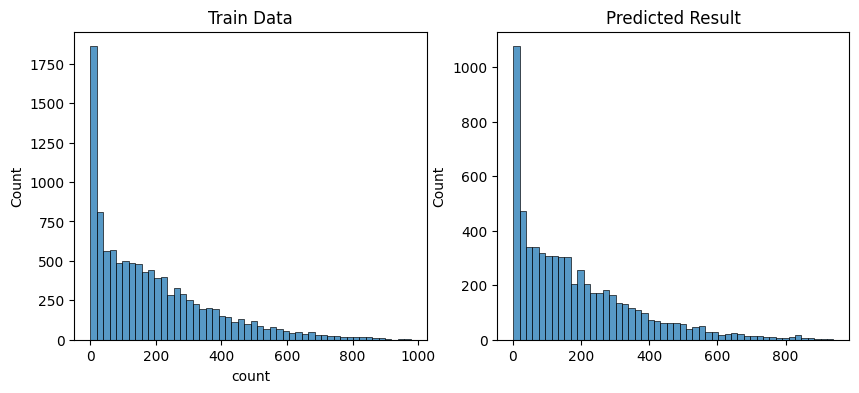

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

randomforest_preds = gridsearch_rf_model.best_estimator_.predict(X_test)

fig, axes = plt.subplots(ncols = 2)
fig.set_size_inches(10,4)

sns.histplot(y, bins = 50, ax = axes[0])
axes[0].set_title("Train Data")
sns.histplot(np.exp(randomforest_preds), bins = 50, ax = axes[1])
axes[1].set_title("Predicted Result")

In [30]:
submission['count'] = np.exp(randomforest_preds)
submission.to_csv(data_path + 'submission.csv', index=False)

In [31]:
submission

,datetime,count
0,2011-01-20 00:00:00,12.161942
1,2011-01-20 01:00:00,5.068784
2,2011-01-20 02:00:00,3.192261
3,2011-01-20 03:00:00,3.588124
4,2011-01-20 04:00:00,2.660928
...,...,...
6488,2012-12-31 19:00:00,211.946965
6489,2012-12-31 20:00:00,168.931634
6490,2012-12-31 21:00:00,97.977605
6491,2012-12-31 22:00:00,100.389750


## 실전문제

In [5]:
train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sampleSubmission.csv')

In [6]:
# 이전 결과에 맞게 이상치 제거

train = train[train['weather'] != 4]

In [7]:
all_data = pd.concat([train, test], ignore_index=True)
print(all_data.head())
all_data.tail()

              datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0     3.0        13.0   16.0  
1        80        0.0     8.0        32.0   40.0  
2        80        0.0     5.0        27.0   32.0  
3        75        0.0     3.0        10.0   13.0  
4        75        0.0     0.0         1.0    1.0  


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
17373,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17374,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17375,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
17376,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN
17377,2012-12-31 23:00:00,1,0,1,1,10.66,13.635,65,8.9981,NaN,NaN,NaN


In [8]:
# 파생피처 생성
from datetime import datetime
all_data['date'] = all_data['datetime'].apply(lambda x: x.split()[0])

all_data['year'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[0])
all_data['month'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[1])
all_data['hour'] = all_data['datetime'].apply(lambda x: x.split()[1].split(':')[0])
all_data['weekday'] = all_data['date'].apply(lambda dateString: datetime.strptime(dateString, "%Y-%m-%d").weekday())

# 필요없는 피쳐 제거

drop_features = ['casual', 'registered', 'datetime', 'date', 'season', 'windspeed']
all_data = all_data.drop(drop_features, axis = 1)

X_train = all_data[~pd.isnull(all_data['count'])] # Y가 없음.
X_test = all_data[pd.isnull(all_data['count'])] # Y가 있음.

X_train = X_train.drop(['count'], axis = 1)
X_test = X_test.drop(['count'], axis = 1)
y = train['count']

In [9]:
X_train.head()

,holiday,workingday,weather,temp,atemp,humidity,year,month,hour,weekday
0,0,0,1,9.84,14.395,81,2011,01,00,5
1,0,0,1,9.02,13.635,80,2011,01,01,5
2,0,0,1,9.02,13.635,80,2011,01,02,5
3,0,0,1,9.84,14.395,75,2011,01,03,5
4,0,0,1,9.84,14.395,75,2011,01,04,5


In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import numpy as np

# Method 1. 수기 계산
def rmsle(y_true, y_pred, convertExp=True):
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
    
    log_true = np.nan_to_num(np.log(y_true+1))
    log_pred = np.nan_to_num(np.log(y_pred-1))

    output = np.sqrt(np.mean((log_true - log_pred) ** 2))
    return output

rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better= False) # 평가지표 제작

randomforest_model = RandomForestRegressor()
rf_params = {'random_state': [42], 'n_estimators': [100,120,140]}
gridsearch_rf_model = GridSearchCV(estimator=randomforest_model,
                                   param_grid=rf_params,
                                   scoring=rmsle_scorer,
                                   cv=5)

log_y = np.log(y)
gridsearch_rf_model.fit(X_train, log_y)

print(gridsearch_rf_model.best_params_)

{'n_estimators': 140, 'random_state': 42}


In [14]:
preds = gridsearch_rf_model.best_estimator_.predict(X_train)

print(f"랜덤 포레스트 RMSLE 값: {rmsle(log_y, preds, True):.4f}")

랜덤 포레스트 RMSLE 값: 0.2665
